In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('../../Datasets/NVDA Historical Data.csv')
df = df[['Open']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Open'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4117.617, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4123.423, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4118.292, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4117.528, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4124.425, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4113.617, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4115.607, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4115.607, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4117.005, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4117.859, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4116.792, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.109 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [4]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Open'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Open'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[135.03061813 135.22294753 135.38514126 135.52852816 135.66017821
 135.78450363 135.90425795 136.02115956 136.13628088 136.25029117
 136.36360809 136.47649231 136.58910648 136.70155212 136.8138926
 136.92616744 137.03840131 137.15060963 137.26280199 137.37498439
 137.48716059 137.5993329  137.7115028  137.82367118 137.93583862
 138.04800548 138.16017197 138.27233822 138.38450434 138.49667037]


In [6]:
# 7. Đánh giá độ chính xác validate, test
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mape(y_test, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mse = mean_squared_error(y_val, y_pred_val)
valid_mae = mean_absolute_error(y_val, y_pred_val)
valid_mape = mape(y_val, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 60.11834021789888
Testing MAE: 43.58049598776466
Testing MAPE: 20.23566819476825
Validation RMSE: 108.69387571390367
Validation MAE: 84.12535577705373
Validation MAPE: 31.214572239776984


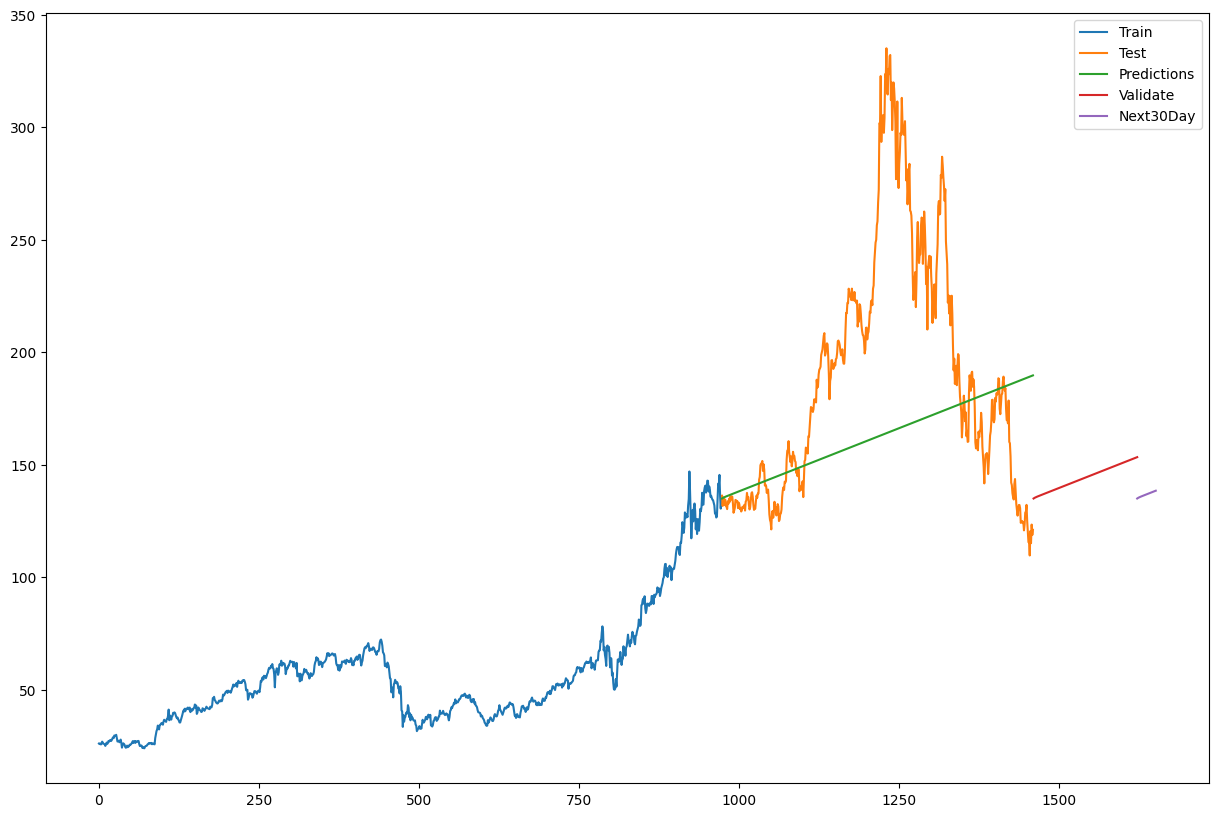

In [7]:
# 9.Vẽ hình
plt.figure(figsize=(15, 10))
plt.plot(train_data.index, train_data['Open'])
plt.plot(test_data.index, test_data['Open'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [8]:
test_data.index

RangeIndex(start=974, stop=1461, step=1)